# Data Cleaning
- Load data that has been processed in OpenRefine and make some general tweaks
- Split est_price into quantity and price columns
    - Cleanup quantity units and convert all values to single unit
    - Cleanup and standardize currency symbols
- Load historical exchange rate data, and convert all data to historical USD using the exchange rate from the month of the 
review date
- Load consumer price index data from BLS. Use this to convert all historical USD prices to January 2024 USD prices
- Cleanup geographic data
    - Create a column for all counties
    - Create a column for US State
    - Check country column is only countries

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('display.max_columns', None)
mpl.rcParams['figure.dpi']= 300

In [2]:
# Read in raw data
data_dir = Path('../../data')
file_path = data_dir / 'interim' / '05052024_roast_review_openrefine.csv'
df_raw = pd.read_csv(file_path)

display(df_raw.info())
display(df_raw.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6539 entries, 0 to 6538
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rating                            6539 non-null   int64  
 1   roaster                           6539 non-null   object 
 2   title                             6539 non-null   object 
 3   blind_assessment                  6539 non-null   object 
 4   bottom_line                       3260 non-null   object 
 5   roaster_location                  6538 non-null   object 
 6   coordinate location               6538 non-null   object 
 7   og_roaster_location               6537 non-null   object 
 8   roaster_location_identifier       6538 non-null   object 
 9   territorial_entity_1              6531 non-null   object 
 10  territorial_entity_1_identifiers  6531 non-null   object 
 11  territorial_entity_2              5889 non-null   object 
 12  territ

None

,rating,roaster,title,blind_assessment,bottom_line,roaster_location,coordinate location,og_roaster_location,roaster_location_identifier,territorial_entity_1,territorial_entity_1_identifiers,territorial_entity_2,territorial_entity_2_identifiers,roaster_country,coffee_origin,coffee_origin_country,roast_level,agtron,est_price,review_date,aroma,body,flavor,aftertaste,with_milk,url,acidity/structure,acidity,notes
3442,92,Crimson Cup Coffee & Tea,Wayfarer Blend,"Rich, round, brisk. Hazelnut, roasted cacao ni...",NaN,Columbus,"39.96222222222222,-83.00055555555555","Columbus, Ohio",Q16567,Franklin County,Q113237,Ohio,Q1397,USA,NaN,Namibia,Light,62/88,$15.95/12 ounces,September 2015,9.0,8.0,9.0,8.0,NaN,https://www.coffeereview.com/review/wayfarer-b...,NaN,8,Composed of a blend of coffees from trees of t...
5732,89,Peet's Coffee & Tea,Garuda Blend,"Lovely aroma: sweet-toned, gently pungent, wit...",NaN,Berkeley,"37.870277777778,-122.26805555556","Berkeley, California",Q484678,Alameda County,Q107146,California,Q99,USA,NaN,Namibia,Dark,33/43,NaN,August 2007,9.0,7.0,8.0,7.0,7.0,https://www.coffeereview.com/review/garuda-blend/,NaN,NaN,Peet's stores do not serve a standard espresso...
2983,93,Old Soul Co.,Nicaragua Reserve Los Congos Pacamara Washed P...,"Delicate yet lush, gently bright. Dried peach,...","Deep yet delicate, sweet yet crisp, quietly co...",Sacramento,"38.575277777778,-121.48611111111","Sacramento, California",Q18013,Sacramento County,Q108131,California,Q99,USA,"San Fernando, Nueva Segovia region, Nicaragua",Nicaragua,Medium-Light,58/82,$20.00/250 grams,January 2017,9.0,9.0,9.0,8.0,NaN,https://www.coffeereview.com/review/nicaragua-...,NaN,8,This lot is comprised entirely of the much adm...
2090,90,Joe Van Gogh Coffee,Ethiopia Sidamo,"Cleanly fruit-toned, aromatic wood-framed. Str...",An easy-drinking natural-processed Ethiopia cu...,Hillsborough,"36.070555555556,-79.104166666667","Hillsborough, North Carolina",Q1008927,Orange County,Q507957,North Carolina,Q1454,USA,"Sidamo (also Sidama) Growing Region, Ethiopia",Ethiopia,Medium-Light,54/70,$13.99/12 ounces,February 2020,8.0,8.0,8.0,8.0,NaN,https://www.coffeereview.com/review/ethiopia-s...,8.0,NaN,This coffee tied for the fourth-highest rating...
2284,93,Cafe Virtuoso,Hawaiian Kona 100%,"Cleanly fruit-toned, richly sweet-tart. Raspbe...","A pretty, richly fruit-toned natural-processed...",San Diego,"32.715,-117.1625","San Diego, California",Q16552,San Diego County,Q108143,California,Q99,USA,"Kona growing region, Big Island, Hawaii, USA",United States of America,Medium,50/70,$40.00/8 ounces,May 2019,9.0,9.0,9.0,8.0,NaN,https://www.coffeereview.com/review/hawaiian-k...,8.0,NaN,Certified organic. Produced by Robert and Dawn...


In [3]:
def tweak_df(df: pd.DataFrame) -> pd.DataFrame:
    """Initial data tweak"""
    return(
        df
        .assign(review_date = lambda df_: pd.to_datetime(df_['review_date'], format="%B %Y"),
                # Combing acidity and acidity/structure into one column, they are the same 
                # field but names used in reviews changed at one point
                acidity = lambda df_: df_['acidity'].fillna(df_['acidity/structure']),
                # Split the agtron column into one for external bean agtron data and ground 
                # bean agtron data
                agtron_external=lambda x: pd.to_numeric(x['agtron']
                                    .str.split('/', expand=True)[0]
                                    .str.strip(), errors='coerce'),
                agtron_ground = lambda x: pd.to_numeric(x['agtron']
                                        .str.split('/', expand=True)[1]
                                        .str.strip(), errors='coerce'
                                        )
        )
        .dropna(subset=['agtron_external', 'agtron_ground', 'acidity',
                        'review_date', 'est_price', 'coffee_origin',
                        'aroma', 'roast_level', 'aftertaste',]
        )
        .drop(columns=['with_milk', 'acidity/structure',])
        .astype({'acidity': 'float'})
        .replace('', np.nan)
        .replace('United States of America', 'USA')
        # Agtron values must be equalt to or below 100, some entries on website have typos 
        .loc[lambda df_: (df_['agtron_external'] <= 100) & (df_['agtron_ground'] <= 100), :]
        # Run str.strip on every string column
        .applymap(lambda x: x.strip() if isinstance(x, str) else x)
    )

df = df_raw.pipe(tweak_df)

display(df.info())
display(df.sample(3))


<class 'pandas.core.frame.DataFrame'>
Index: 4375 entries, 1 to 5163
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            4375 non-null   int64         
 1   roaster                           4375 non-null   object        
 2   title                             4375 non-null   object        
 3   blind_assessment                  4375 non-null   object        
 4   bottom_line                       2860 non-null   object        
 5   roaster_location                  4375 non-null   object        
 6   coordinate location               4375 non-null   object        
 7   og_roaster_location               4375 non-null   object        
 8   roaster_location_identifier       4375 non-null   object        
 9   territorial_entity_1              4373 non-null   object        
 10  territorial_entity_1_identifiers  4373 non-null   obj

None

,rating,roaster,title,blind_assessment,bottom_line,roaster_location,coordinate location,og_roaster_location,roaster_location_identifier,territorial_entity_1,territorial_entity_1_identifiers,territorial_entity_2,territorial_entity_2_identifiers,roaster_country,coffee_origin,coffee_origin_country,roast_level,agtron,est_price,review_date,aroma,body,flavor,aftertaste,url,acidity,notes,agtron_external,agtron_ground
1280,93,Kakalove Cafe,Ethiopia Natural Guji Hambela SASA Lot 10,"Richly sweet-tart, deeply berry-toned. Fresh b...","A richly berry-toned Ethiopia natural: clean, ...",Chiayi City,"23.48,120.44972222222","Chia-Yi, Taiwan",Q249995,Taiwan Province,Q32081,Taiwan,Q865,Taiwan,"Guji Zone, Oromia Region, Ethiopia",Ethiopia,Light,62/80,NT $325/8 ounces,2021-10-01,9.0,9.0,9.0,8.0,https://www.coffeereview.com/review/ethiopia-n...,8.0,Southern Ethiopia coffees like this one are la...,62.0,80.0
3371,92,Red Rooster Coffee Roaster,Ethiopia Hambela Washed,"Light, intricate, zesty. Black currant, lemon,...",NaN,Floyd,"36.9122,-80.3183","Floyd, Virginia",Q1376660,Floyd County,Q502031,Virginia,Q1370,USA,"Hambela District, Oromia Growing Region, Ethi...",Ethiopia,Medium-Light,52/72,$13.99/12 ounces,2015-11-01,9.0,8.0,9.0,8.0,https://www.coffeereview.com/review/ethiopia-h...,8.0,Oromia is a coffee region in southern Ethiopia...,52.0,72.0
155,91,Cafe Fugu Roasters,Ethiopia Bench Maji Lucy Station Geisha Washed,"Sweetly tart, balanced. Pomegranate, lily, cas...","A brightly sweet, gently tart washed Ethiopia ...",New Taipei,"25.011111,121.445833","Taipei City, Taiwan",Q244898,Taiwan,Q865,NaN,NaN,Taiwan,"Bench-maji Zone, Ethiopia",Ethiopia,Light,71/92,NT$ 650/200 grams,2024-01-01,8.0,8.0,9.0,8.0,https://www.coffeereview.com/review/ethiopia-b...,8.0,Produced from trees of the rare Ethiopia-deriv...,71.0,92.0


## Quantity and Price Data Cleaning
Here we will split est_price into a column for quantity, quantity unit, price, and currency. Currency symbols will be standardized to  ISO 4217 codes and all prices will be converted to USD. Quanity units will be cleaned then used to create a column for quantity in lbs. 

In [4]:
def price_quantity_split(df: pd.DataFrame) -> pd.DataFrame:
    price_quantity = (
        df
        # Split est_price into columns for price and quantity
        .est_price.str.split("/", n=1, expand=True)   
        # Remove , from numbers
        .replace(',', '', regex=True)
        .rename(columns={0: 'price', 1: 'quantity'})
        .assign(quantity = lambda df_: (df_['quantity']
                                        # Remove anything in parentheses, including the parentheses
                                        .str.replace(r"\(.*?\)", "", regex=True)
                                        # Remove anything after a semicolon
                                        .str.replace(r";.*", "", regex=True)
                                        # Standardize units
                                        .str.replace(r".g$", " grams", regex=True)
                                        .str.replace(r"\sg$", "grams", regex=True)
                                        .str.replace(r"pound$", "1 pounds", regex=True)
                                        .str.replace(r"oz|onces|ounce$|ounces\*", "ounces", regex=True)
                                        # Removie "online" from any quantity
                                        .str.replace("online", "")
                                        .str.strip()
                                        )
            )
        .dropna()
        # Remove rows where coffee is sold in a can, box, pouch, packet, or tin
        .loc[lambda df_: ~df_['quantity'].str.contains('can|box|capsules|K-|cups|pods|pouch|packet|tin'), :]
        # Split quantity into value and unit, and split price into value and currency
        .assign(quantity_value = lambda df_: (df_['quantity']
                                              .str.extract(r'(\d+)')
                                              .astype(float)
                                              ),
                quantity_unit = lambda df_: (df_['quantity']
                                             .str.replace(r"(\d+)", "", regex=True)
                                             .replace("\.", "", regex=True)
                                             .str.strip()
                                             .mask(lambda s: s == 'g', 'grams')
                                             .str.strip()
                                             ),
                price_value = lambda df_: (df_['price']
                                           .str.extract(r'(\d+\.\d+|\d+)')
                                           .astype(float)
                                           ),
                price_currency = lambda df_: (df_['price']
                                              .str.replace(",", "")
                                              .str.replace(r'(\d+\.\d+|\d+)', '', regex=True)
                                              .str.strip()
                                              )
                )
        # Now that price and quantity have been split, drop the original columns
        .drop(columns=['price', 'quantity'])
    )
    # Merge the price_quantity DataFrame with the original DataFrame
    return df.merge(price_quantity, left_index=True, right_index=True)


df = (df_raw
      .pipe(tweak_df)
      .pipe(price_quantity_split)
      )

display(df.info())
display(df.loc[:, ['price_value', 'quantity_value']].describe())
display(df['price_currency'].value_counts())   
display(df['quantity_unit'].value_counts()) 

<class 'pandas.core.frame.DataFrame'>
Index: 4318 entries, 1 to 5163
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            4318 non-null   int64         
 1   roaster                           4318 non-null   object        
 2   title                             4318 non-null   object        
 3   blind_assessment                  4318 non-null   object        
 4   bottom_line                       2846 non-null   object        
 5   roaster_location                  4318 non-null   object        
 6   coordinate location               4318 non-null   object        
 7   og_roaster_location               4318 non-null   object        
 8   roaster_location_identifier       4318 non-null   object        
 9   territorial_entity_1              4316 non-null   object        
 10  territorial_entity_1_identifiers  4316 non-null   obj

None

,price_value,quantity_value
count,4318.000000,4318.000000
mean,312.869243,35.117647
std,3831.361572,68.595875
min,3.300000,1.000000
25%,16.000000,12.000000
50%,19.500000,12.000000
75%,35.000000,12.000000
max,120000.000000,554.000000


price_currency
$           3461
NT $         578
CAD $         94
NT$           43
NTD $         20
HKD $         16
RMB $          9
AUD $          9
KRW            9
¥              9
NT             8
KRW $          7
TWD $          7
£              6
HK $           5
AED $          5
IDR $          3
$ NTD          3
THB $          3
THB            2
US $           2
USD $          2
#              2
RMB            2
GBP            2
$NT            1
               1
pesos          1
$NT$           1
Nt $           1
CNY $          1
KRW$           1
E              1
GTQ            1
Price: $       1
$ CAD          1
Name: count, dtype: int64

quantity_unit
ounces      3765
grams        540
pounds        12
kilogram       1
Name: count, dtype: int64

#### Cleaning Currencies



In [5]:
def clean_currency(df: pd.DataFrame) -> pd.DataFrame:
    """Standardiz currencies to ISO 4217 codes."""
    price_currency = (
        df.price_currency
        .str.upper()
        .str.replace(r'^\$$', 'USD', regex=True)
        .str.replace('PRICE: $', 'USD')
        .str.replace('$', '')
        .str.replace('#', 'GBP')
        .str.replace('¥', 'JPY')
        .str.replace('£', 'GBP')
        .str.replace('POUND', 'GBP')
        .str.replace('PESOS', 'MXN')
        .str.replace('RMB', 'CNY')
        .str.strip()
        .mask(lambda s: s == "US", "USD")
        .mask(lambda s: s == ' ', "USD")
        .mask(lambda s: s == 'E', 'EUR')
        .mask(lambda s: s == 'NTD', 'TWD')
        .mask(lambda s: s == 'NT', 'TWD')
        .mask(lambda s: s == '', 'USD')
        .mask(lambda s: s == 'HK', 'HKD')
        .str.strip()
    )
    return df.assign(price_currency=price_currency)

df = df_raw.pipe(tweak_df).pipe(price_quantity_split).pipe(clean_currency)
df.loc[:, ["est_price", "price_currency"]].groupby('price_currency').sample(3, replace=True)

,est_price,price_currency
2490,AED $103.95/250 grams,AED
473,AED $99.75/250 grams,AED
2230,AED $103.95/250 grams,AED
3180,AUD $18.00/250 grams,AUD
2176,AUD $18.00/18 grams,AUD
3175,AUD $22.00/250 grams,AUD
4757,CAD $11.95/12 ounces,CAD
4356,CAD $16.85/12 ounces,CAD
4053,CAD $11.95/12 ounces,CAD
3364,RMB $235/125 grams,CNY


### Converting prices to 2024 USD
1. Convert price to USD using historical exchange rates
2. Adjust price to 2024 USD using BLS consumer price index

In [6]:
def convert_row(row):
    date = row['review_date'].strftime('%Y-%m-%d')
    currency = row['price_currency']
    price = row['price_value']
    if currency == 'USD':
        return price
    else:
        return np.round(price / exchange_rates[date][currency], 2)
    
def convert_to_usd(df: pd.DataFrame) -> pd.DataFrame:
    df['price_value_usd_hist'] = df.apply(convert_row, axis=1)
    return df
    
with open(data_dir / 'external' / 'openex_exchange_rates.json') as f:
    exchange_rates = json.load(f)

df = (df_raw
      .pipe(tweak_df)
      .pipe(price_quantity_split)
      .pipe(clean_currency)
      .pipe(convert_to_usd)
      )

(
    df
    .loc[:, ['price_value','price_currency', 'price_value_usd_hist']]
    .groupby('price_currency')
).sample(3, replace= True)

,price_value,price_currency,price_value_usd_hist
473,99.75,AED,27.16
2230,103.95,AED,28.30
2215,99.75,AED,27.16
3159,15.00,AUD,11.26
3180,18.00,AUD,13.05
3182,23.00,AUD,16.68
3589,15.99,CAD,12.59
5056,16.00,CAD,15.23
4774,15.20,CAD,16.05
3655,60.00,CNY,9.81


<Axes: title={'center': '% Price difference between adjusted and historical prices'}, xlabel='review_date'>

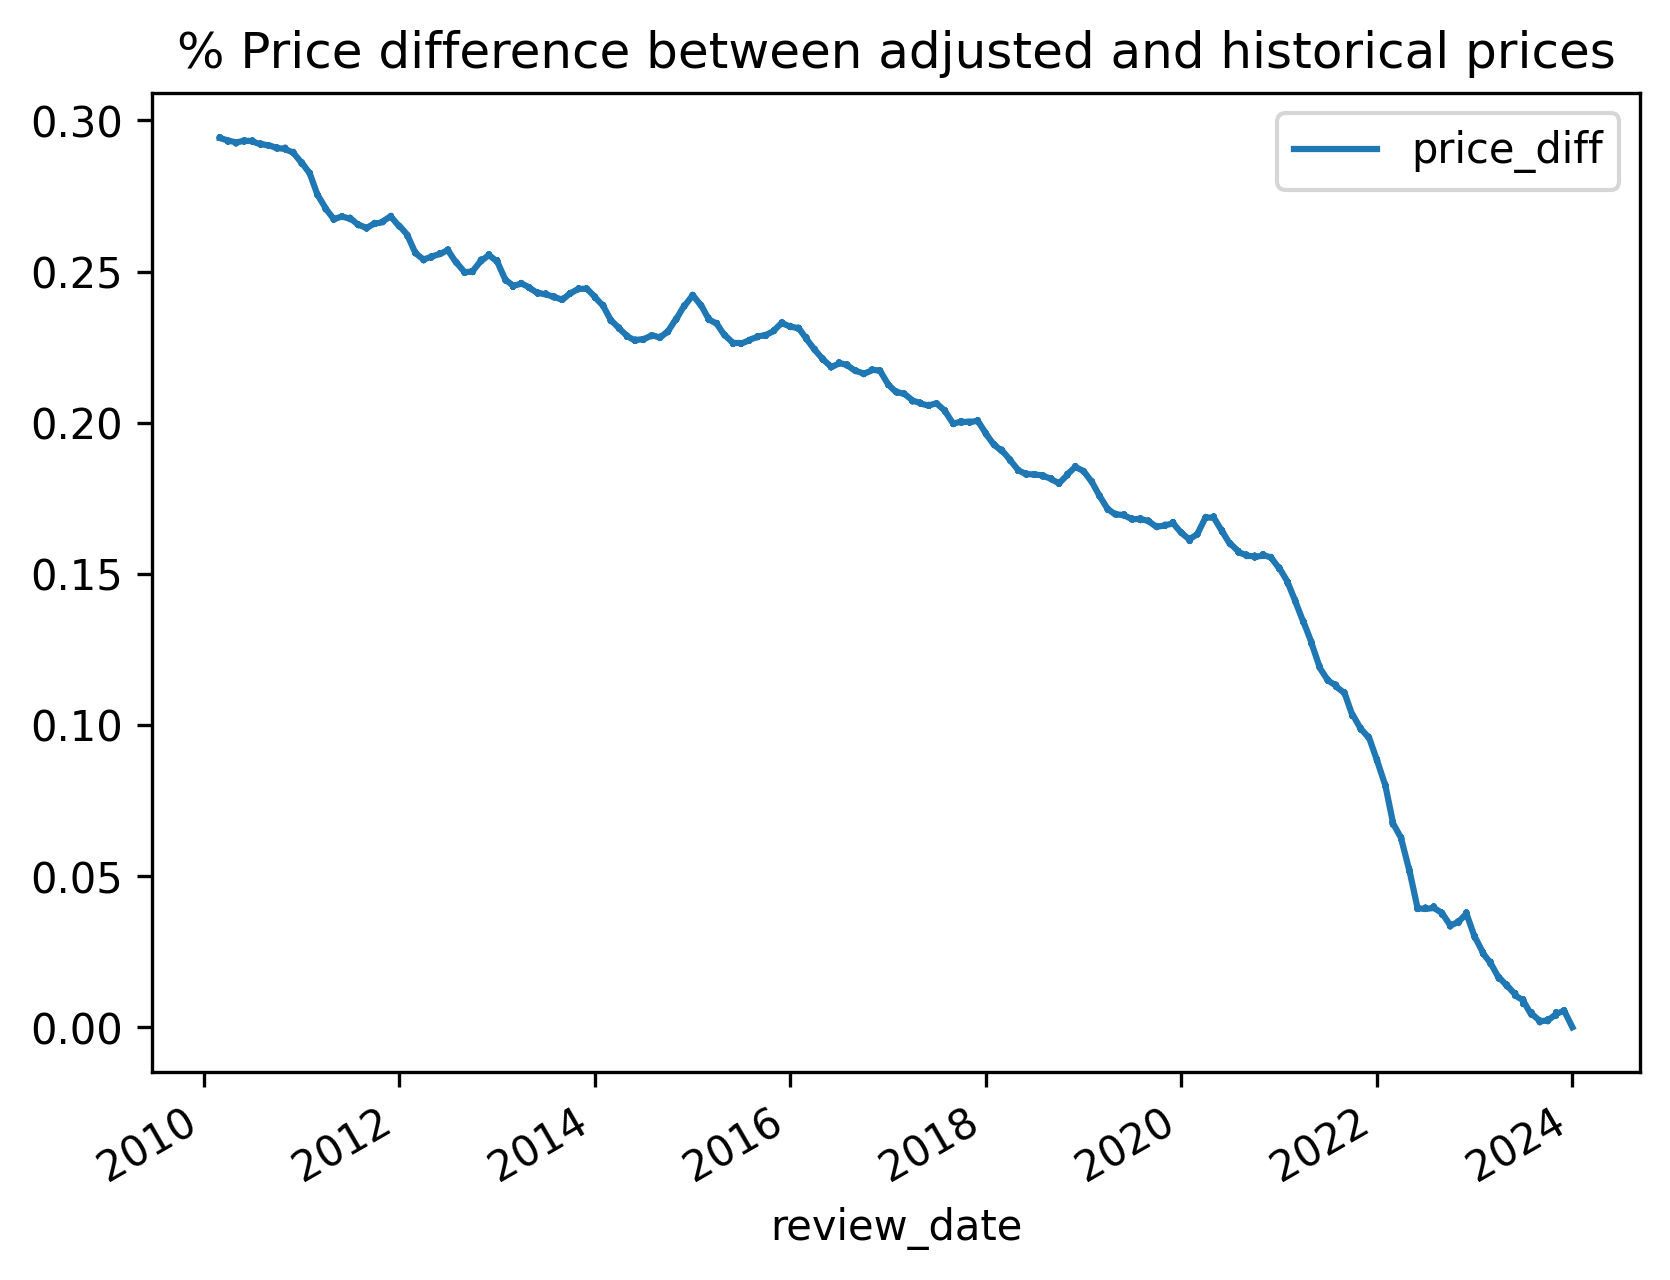

In [7]:

def load_transform_cpi(file_path: Path) -> pd.DataFrame:
    """Loads and transforms the CPI data."""
    MONTH_MAP = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }

    try:
        cpi = pd.read_csv(file_path, usecols=['Year',
                                              'Jan', 'Feb', 'Mar',
                                              'Apr', 'May', 'Jun',
                                              'Jul', 'Aug', 'Sep',
                                              'Oct', 'Nov', 'Dec'
                                              ]
                          )
    except FileNotFoundError:
        raise FileNotFoundError("CPI file is not found in the specified directory.")

    return (cpi
            .melt(id_vars='Year', var_name='Month', value_name='cpi')
            .assign(Month=lambda x: x['Month'].map(MONTH_MAP),
                    date=lambda x: pd.to_datetime(x[['Year', 'Month']].assign(day=1)))
            .dropna()
            .drop(columns=['Year', 'Month'])
            .rename(columns={'cpi': 'consumer_price_index'})
            .sort_values('date')
            .reset_index(drop=True)
           )
    
def create_cpi_adjusted_price(df: pd.DataFrame, file_path: Path, date: str='2024-01-01') -> pd.DataFrame:
    """
    Adjusts historical price data to 2024 prices using CPI data.
    """
    cpi = load_transform_cpi(file_path)
    cpi_baseline = cpi.loc[cpi['date'] == date, 'consumer_price_index'].values[0]
    
    return (df
            .merge(cpi, left_on="review_date", right_on="date")
            .drop(columns='date')
            .assign(price_usd_adj_2024=lambda df_: np.round(
                df_['price_value_usd_hist'] * cpi_baseline / df_['consumer_price_index'], 2)
                    )
            )
    
data_dir = Path('../../data')
cpi_path = data_dir / 'external' / 'consumer_price_index.csv'

df = (df_raw
      .pipe(tweak_df)
      .pipe(price_quantity_split)
      .pipe(clean_currency)
      .pipe(convert_to_usd)
      .pipe(create_cpi_adjusted_price, file_path=cpi_path)
      )

df.sample(3)    

(
    df
    .assign(price_diff=lambda df_: (df_['price_usd_adj_2024'] - df_['price_value_usd_hist'])/df_['price_usd_adj_2024'])
).plot(x='review_date', y='price_diff', title='% Price difference between adjusted and historical prices')


### Converting quantities to lbs

In [8]:
def convert_to_lbs(df: pd.DataFrame) -> pd.DataFrame:
    to_lbs_conversion = {"ounces": 1/16, "pounds":1, "kilogram": 2.20462, "grams": 0.00220462}
    df['quantity_in_lbs'] = np.round(df['quantity_value'] * df['quantity_unit'].map(to_lbs_conversion), 2)
    return df

df =(df_raw
     .pipe(tweak_df)
     .pipe(price_quantity_split)
     .pipe(clean_currency)
     .pipe(convert_to_usd)
     .pipe(create_cpi_adjusted_price, file_path=cpi_path)
     .pipe(convert_to_lbs)
)

display(df.loc[:, ['quantity_value', 'quantity_unit', 'quantity_in_lbs']]
        .groupby("quantity_unit")
        .sample(3, replace=True)
)

,quantity_value,quantity_unit,quantity_in_lbs
111,200.0,grams,0.44
2830,250.0,grams,0.55
6,227.0,grams,0.50
3479,1.0,kilogram,2.20
3479,1.0,kilogram,2.20
3479,1.0,kilogram,2.20
4114,8.0,ounces,0.50
2966,12.0,ounces,0.75
1608,12.0,ounces,0.75
4177,1.0,pounds,1.00


In [38]:
# Create a new column for price per pound
def price_per_lbs(df: pd.DataFrame) -> pd.DataFrame:
    df['price_usd_adj_2024_per_lb'] = np.round(df['price_usd_adj_2024'] / df['quantity_in_lbs'], 2)
    return df

df = (df_raw
      .pipe(tweak_df)
      .pipe(price_quantity_split)
      .pipe(clean_currency)
      .pipe(convert_to_usd)
      .pipe(create_cpi_adjusted_price, file_path=cpi_path)
      .pipe(convert_to_lbs)
      .pipe(price_per_lbs)
)

display(df.describe())

,rating,review_date,aroma,body,flavor,aftertaste,acidity,agtron_external,agtron_ground,quantity_value,price_value,price_value_usd_hist,consumer_price_index,price_usd_adj_2024,quantity_in_lbs,price_usd_adj_2024_per_lb
count,4232.000000,4232,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000
mean,92.724008,2018-02-15 12:47:38.223062272,8.761815,8.505671,8.922968,8.108223,8.418242,56.076796,74.330577,34.909972,316.062042,21.902857,257.527393,26.267590,0.673020,50.704308
min,75.000000,2010-03-01 00:00:00,5.000000,6.000000,3.000000,4.000000,5.000000,0.000000,30.000000,1.000000,3.300000,3.300000,217.631000,3.880000,0.040000,5.360000
25%,92.000000,2014-08-01 00:00:00,9.000000,8.000000,9.000000,8.000000,8.000000,53.000000,71.000000,12.000000,15.990000,14.950000,236.525000,18.437500,0.500000,25.600000
50%,93.000000,2018-10-01 00:00:00,9.000000,9.000000,9.000000,8.000000,8.000000,57.000000,76.000000,12.000000,19.500000,18.000000,252.038000,21.785000,0.750000,30.425000
75%,94.000000,2021-11-01 00:00:00,9.000000,9.000000,9.000000,8.000000,9.000000,60.000000,80.000000,12.000000,34.950000,22.950000,277.948000,26.272500,0.750000,41.345000
max,98.000000,2024-01-01 00:00:00,10.000000,10.000000,10.000000,10.000000,10.000000,86.000000,99.000000,554.000000,120000.000000,387.480000,308.417000,388.420000,6.000000,5180.000000
std,1.888504,NaN,0.510330,0.536950,0.457322,0.558646,0.600502,6.355795,8.445195,68.378544,3869.941660,16.731940,26.992464,19.524478,0.227317,123.361985


In [10]:
# list of US states
us_states_and_territories= [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
    'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
    'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
    'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
    'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
    'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
    'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
    'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
    'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming',
    'District of Columbia', 'Puerto Rico'
]

# Create a column for county. Set it eual to the value in territorial_entity_1 if it contains 'County'

def create_us_state(row):
    if row['territorial_entity_2'] in us_states_and_territories:
        return row['territorial_entity_2']
    elif row['territorial_entity_1'] in us_states_and_territories:
        return row['territorial_entity_1']
    elif row['og_roaster_location'].split(",")[-1].strip() in us_states_and_territories:
        return row['og_roaster_location'].split(",")[-1].strip()
    else:
        return np.nan


def create_county_and_state_columns(df: pd.DataFrame) -> pd.DataFrame:
    df['roaster_county'] = np.where(df['territorial_entity_1'].str.contains('County', na=False),
                                    df['territorial_entity_1'],
                                    np.nan)
    df['roaster_us_state'] = df.apply(create_us_state, axis=1)
    return df


df = (df_raw
      .pipe(tweak_df)
        .pipe(price_quantity_split)
        .pipe(clean_currency)
        .pipe(convert_to_usd)
        .pipe(create_cpi_adjusted_price, file_path=cpi_path)
        .pipe(convert_to_lbs)
        .pipe(price_per_lbs)
        .pipe(create_county_and_state_columns)
        
)


display(df.loc[df['roaster_country'] == 'USA', ['roaster_country', 'roaster_us_state', 'roaster_county']].info())

<class 'pandas.core.frame.DataFrame'>
Index: 3227 entries, 0 to 4231
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   roaster_country   3227 non-null   object
 1   roaster_us_state  3227 non-null   object
 2   roaster_county    2905 non-null   object
dtypes: object(3)
memory usage: 100.8+ KB


None

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4232 entries, 0 to 4231
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            4232 non-null   int64         
 1   roaster                           4232 non-null   object        
 2   title                             4232 non-null   object        
 3   blind_assessment                  4232 non-null   object        
 4   bottom_line                       2760 non-null   object        
 5   roaster_location                  4232 non-null   object        
 6   coordinate location               4232 non-null   object        
 7   og_roaster_location               4232 non-null   object        
 8   roaster_location_identifier       4232 non-null   object        
 9   territorial_entity_1              4231 non-null   object        
 10  territorial_entity_1_identifiers  4231 non-null 

## Column Checks

In [39]:
df = (df_raw
        .pipe(tweak_df)
        .pipe(price_quantity_split)
        .pipe(clean_currency)
        .pipe(convert_to_usd)
        .pipe(create_cpi_adjusted_price, file_path=cpi_path)
        .pipe(convert_to_lbs)
        .pipe(price_per_lbs)
        .pipe(create_county_and_state_columns)
    )

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4232 entries, 0 to 4231
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            4232 non-null   int64         
 1   roaster                           4232 non-null   object        
 2   title                             4232 non-null   object        
 3   blind_assessment                  4232 non-null   object        
 4   bottom_line                       2760 non-null   object        
 5   roaster_location                  4232 non-null   object        
 6   coordinate location               4232 non-null   object        
 7   og_roaster_location               4232 non-null   object        
 8   roaster_location_identifier       4232 non-null   object        
 9   territorial_entity_1              4231 non-null   object        
 10  territorial_entity_1_identifiers  4231 non-null 

In [40]:
df_numeric = df.select_dtypes(include=['number']).drop(columns=['price_value'], axis=1)
len(df_numeric.columns)

14

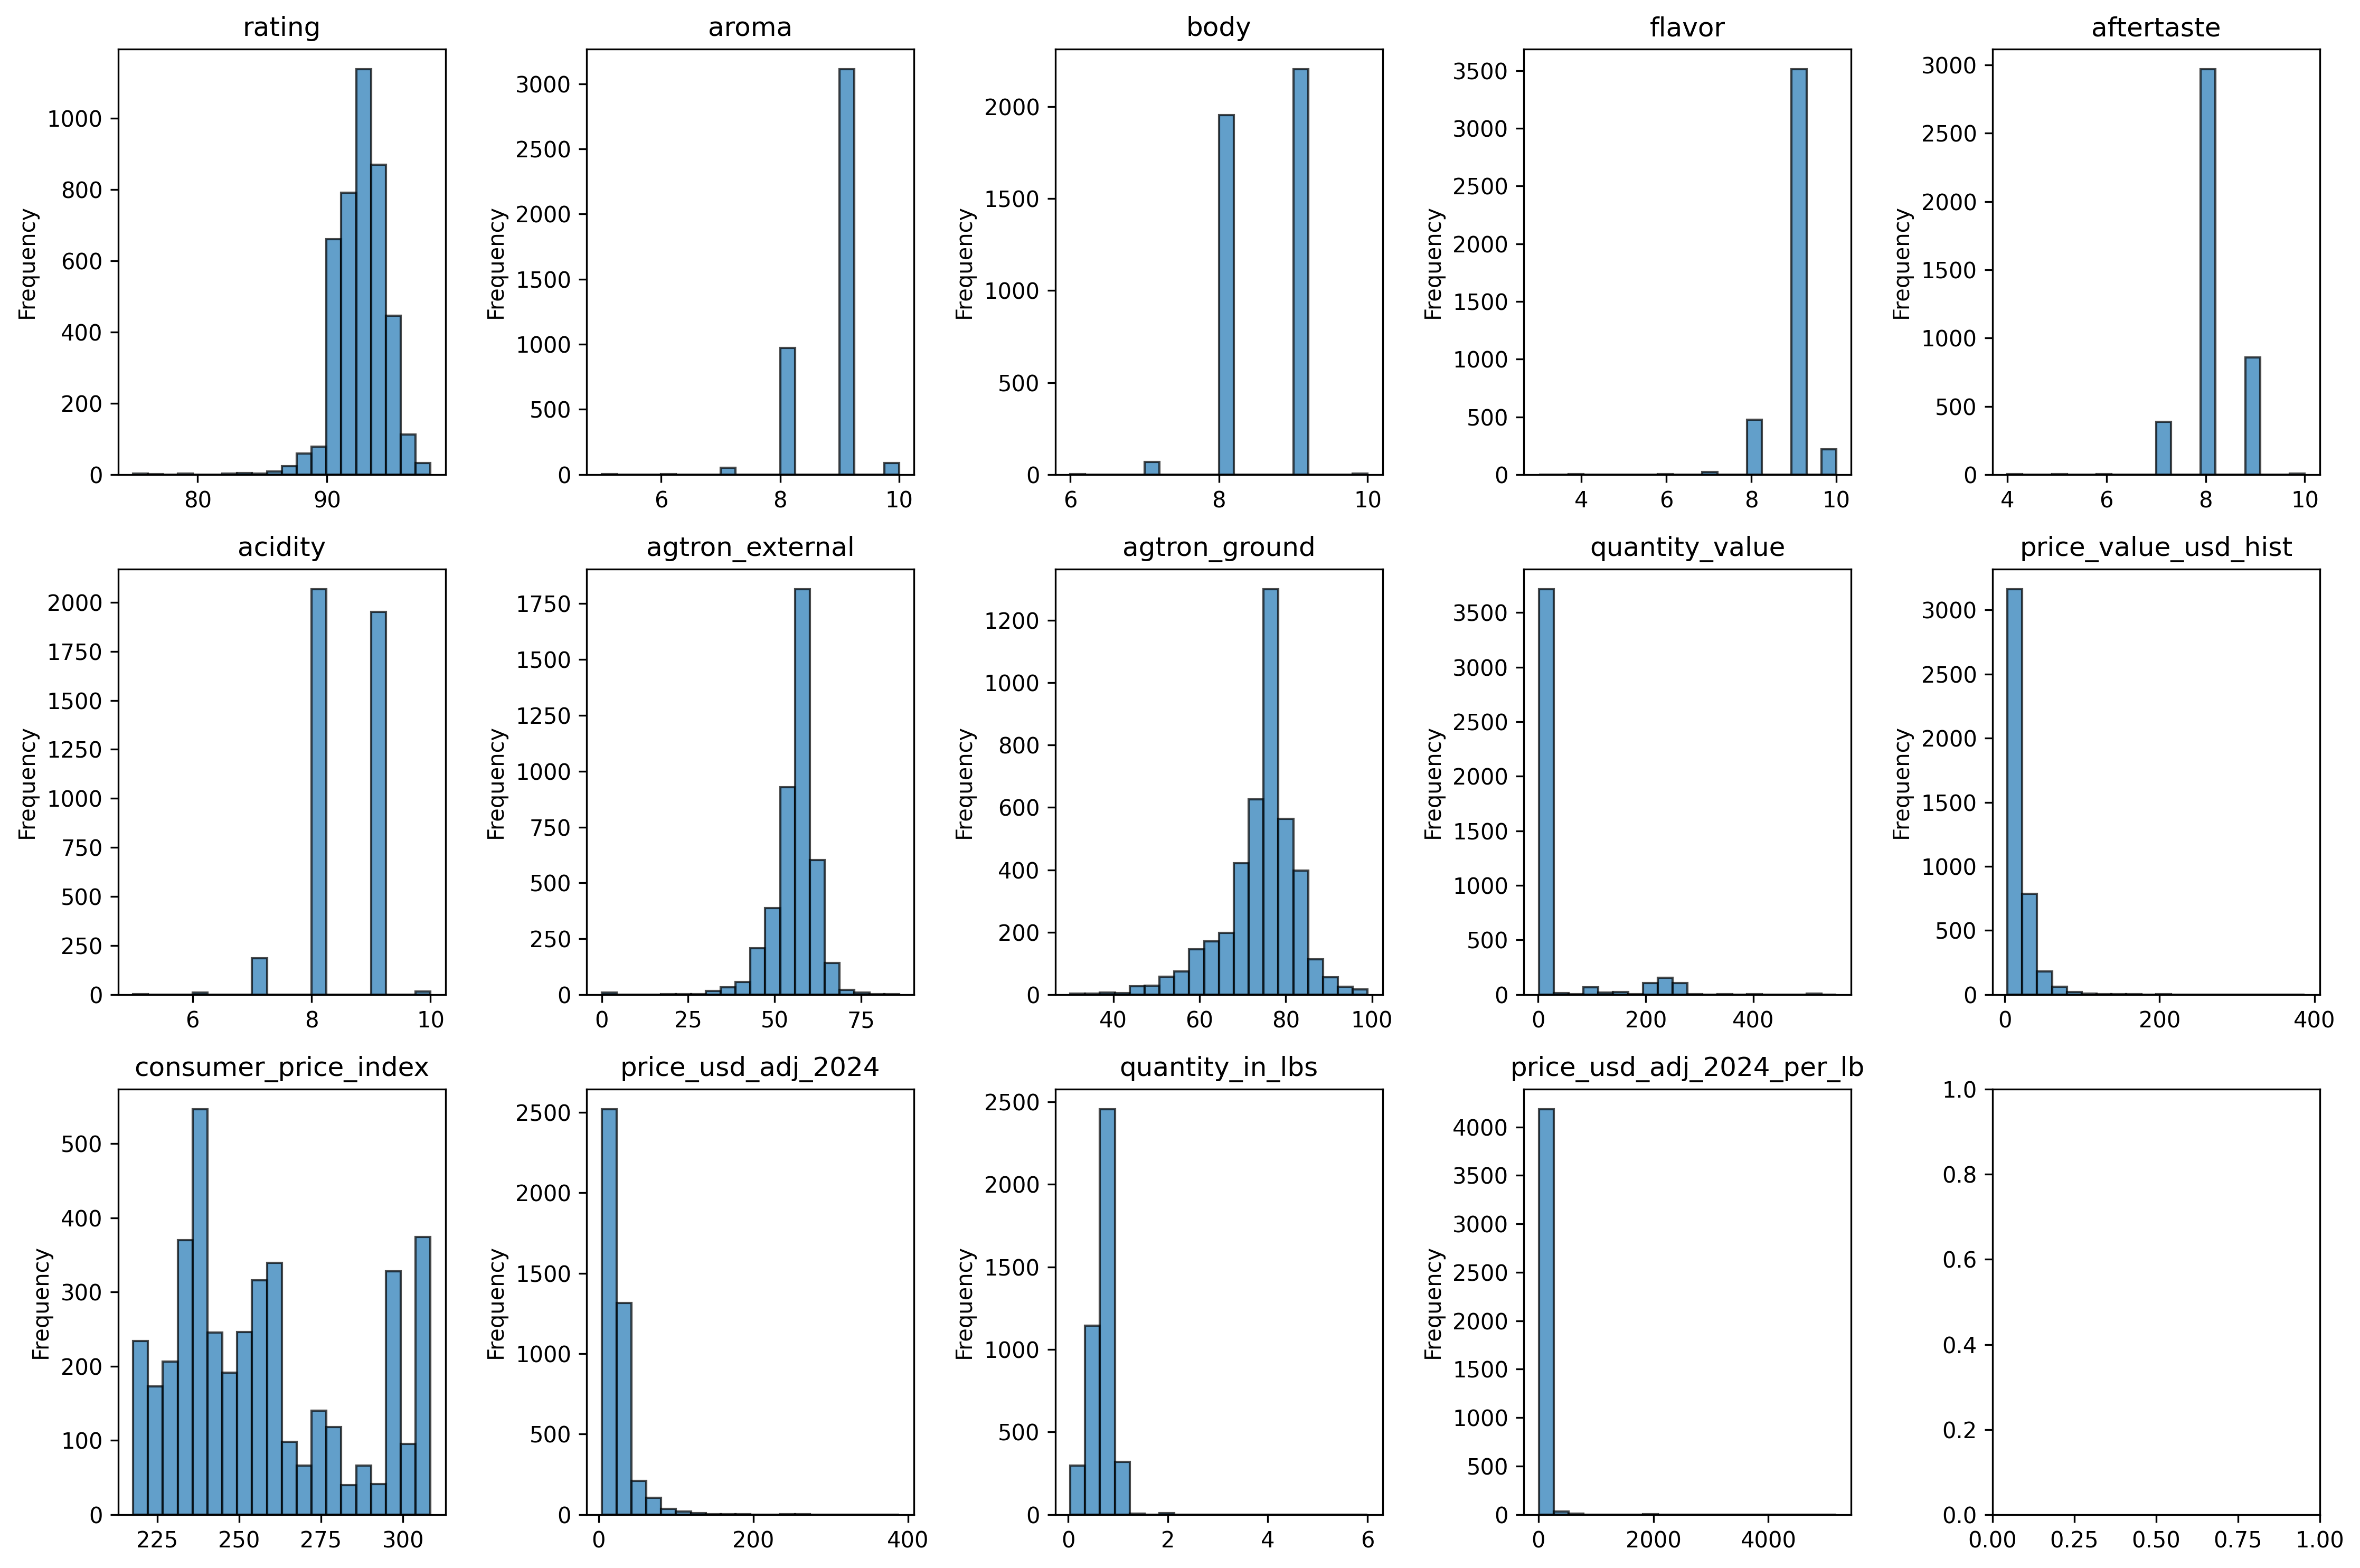

In [41]:
fig, ax = plt.subplots(3, 5, figsize=(15, 10))

for i, col in enumerate(df_numeric.columns):
    df[col].plot(kind='hist', ax=ax[i//5, i%5], title=col, bins=20, edgecolor='black', alpha=0.7)
    
plt.tight_layout()
plt.show()

array([[<Axes: title={'center': 'price_usd_adj_2024_per_lb'}>]],
      dtype=object)

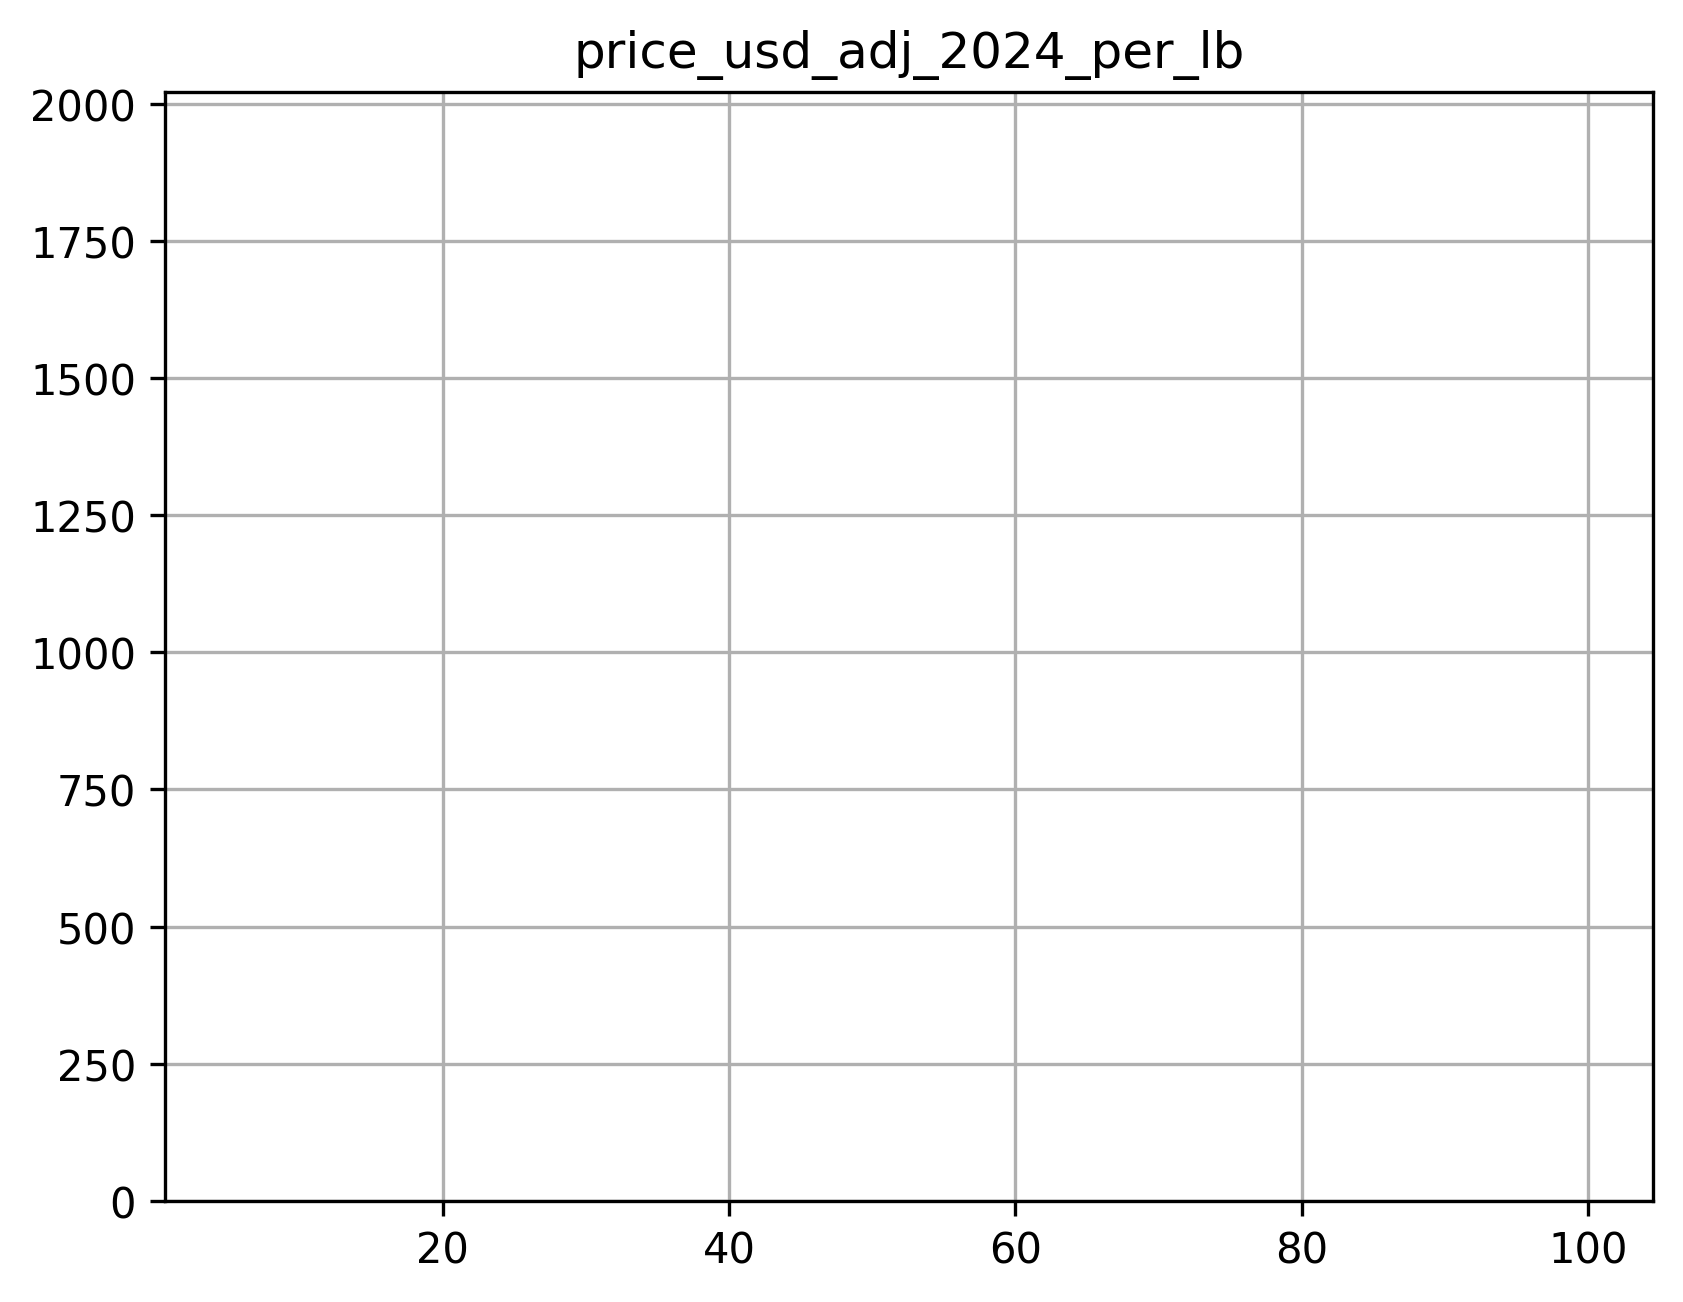

In [42]:
df[df.price_usd_adj_2024_per_lb < 100].hist('price_usd_adj_2024_per_lb', edgecolor='black', alpha=0.)

Text(0.5, 1.0, 'Cumulative Histogram Price $USD/lbs')

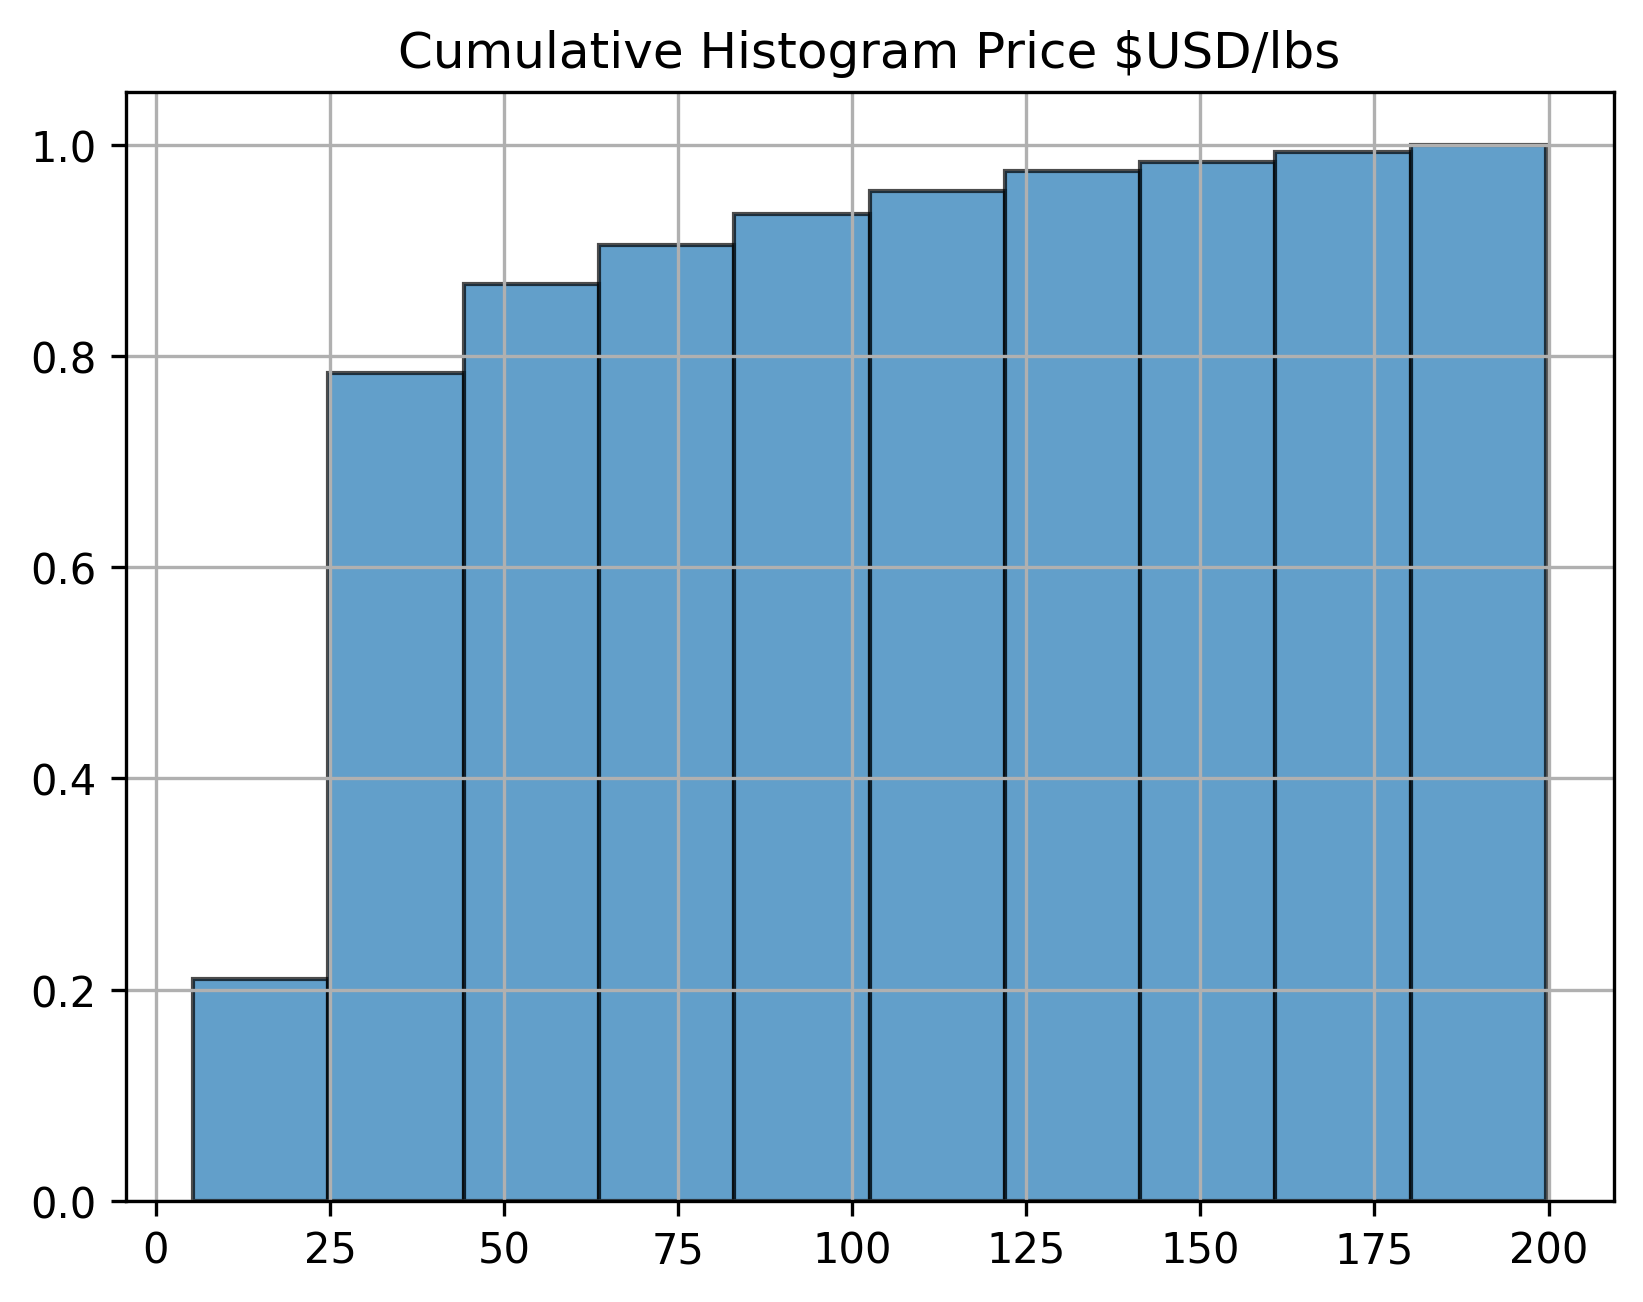

In [36]:
df[df['price_per_lbs_usd_adj_2024'] < 200].price_per_lbs_usd_adj_2024.hist(cumulative=True,
                                                                           density=True,
                                                                           edgecolor='black',
                                                                           alpha=0.7)
plt.title("Cumulative Histogram Price $USD/lbs")

In [20]:
# Checking countries
display(df.roaster_country.sort_values().unique())
display(df.coffee_origin_country.sort_values().unique())

array(['Australia', 'Canada', 'Colombia', 'Costa Rica',
       'Democratic Republic of the Congo', 'Guatemala', 'Honduras',
       'Indonesia', 'Japan', 'Kenya', 'Mexico', 'Netherlands',
       "People's Republic of China", 'Peru', 'Rwanda', 'South Korea',
       'Taiwan', 'Thailand', 'USA', 'Uganda', 'United Arab Emirates',
       'United Kingdom'], dtype=object)

array(['Bolivia', 'Brazil', 'Burundi', 'Colombia', 'Costa Rica',
       'Democratic Republic of the Congo', 'Dominican Republic',
       'Ecuador', 'El Salvador', 'Ethiopia', 'Guatemala', 'Haiti',
       'Honduras', 'India', 'Indonesia', 'Jamaica', 'Kenya', 'Madagascar',
       'Malawi', 'Malaysia', 'Mexico', 'Myanmar', 'Nepal', 'Nicaragua',
       'Panama', 'Papua New Guinea', "People's Republic of China", 'Peru',
       'Philippines', 'Rwanda', 'Saint Helena', 'South Africa', 'Taiwan',
       'Tanzania', 'Thailand', 'USA', 'Uganda', 'Vietnam', 'Yemen',
       'Zambia', 'Zimbabwe'], dtype=object)

In [43]:
# Checking roast level
df.roast_level.value_counts()

roast_level
Medium-Light    2609
Light            765
Medium           700
Medium-Dark      127
Dark              19
Very Dark         12
Name: count, dtype: int64

In [44]:
# Quantity outliers
df[df.quantity_in_lbs > 2]

,rating,roaster,title,blind_assessment,bottom_line,roaster_location,coordinate location,og_roaster_location,roaster_location_identifier,territorial_entity_1,territorial_entity_1_identifiers,territorial_entity_2,territorial_entity_2_identifiers,roaster_country,coffee_origin,coffee_origin_country,roast_level,agtron,est_price,review_date,aroma,body,flavor,aftertaste,url,acidity,notes,agtron_external,agtron_ground,quantity_value,quantity_unit,price_value,price_currency,price_value_usd_hist,consumer_price_index,price_usd_adj_2024,quantity_in_lbs,price_usd_adj_2024_per_lb,roaster_county,roaster_us_state
1960,90,Kirkland Signature (Costco),Colombian Supremo,"Roasty-sweet, spice-toned. Banana, orange blos...",A deftly dark-roasted Colombia coffee with spi...,Lincoln,"38.887222222222,-121.29611111111","Lincoln, California",Q966492,Placer County,Q156353,California,Q99,USA,"Concordia, Colombia",Colombia,Medium-Dark,40/54,$17.99/3 pounds,2019-05-01,8.0,8.0,9.0,7.0,https://www.coffeereview.com/review/colombian-...,8.0,A washed-process coffee produced entirely of t...,40.0,54.0,3.0,pounds,17.99,USD,17.99,256.092,21.67,3.0,7.22,Placer County,California
1969,87,Kirkland Signature (Costco),Rwandan,"Crisp, chocolaty, roast-framed. Baker’s chocol...","An intensely aromatic, roasty wood-framed cup ...",Seattle,"47.60621,-122.33207","Seattle, Washington",Q5083,King County,Q108861,Washington,Q1223,USA,Rwanda,Rwanda,Medium-Dark,37/49,$37.99/6 pounds,2019-05-01,7.0,8.0,8.0,7.0,https://www.coffeereview.com/review/rwandan-2/,7.0,Costco is a membership-only wholesaler and ret...,37.0,49.0,6.0,pounds,37.99,USD,37.99,256.092,45.75,6.0,7.62,King County,Washington
3479,86,CoffeeIndy.com,Single Origin Chiang Rai Doi Chang,Delicately sweet roast-influenced profile. Mil...,NaN,Bangkok,"13.75,100.51666666667","Bangkok, Thailand",Q1861,Thailand,Q869,NaN,NaN,Thailand,"Chiang Rai, Thailand",Thailand,Dark,37/44,THB $600/1 kilogram,2013-06-01,7.0,7.0,8.0,7.0,https://www.coffeereview.com/review/single-ori...,7.0,CoffeeIndy is a coffee roaster and retailer lo...,37.0,44.0,1.0,kilogram,600.00,THB,19.75,233.504,26.09,2.2,11.86,NaN,NaN
3930,88,Equal Exchange,Organic Guatemalan Medium,"Roasted nut, fresh-cut fir and a brightening o...",NaN,West Bridgewater,"42.018888888889,-71.008333333333","West Bridgewater, Massachusetts",Q2416264,Plymouth County,Q54086,Massachusetts,Q771,USA,"El Quiche Department, South Guatemala",Guatemala,Medium,48/56,$57.00/5 pounds,2011-07-01,7.0,8.0,8.0,8.0,https://www.coffeereview.com/review/organic-gu...,7.0,Available online in five-pound bags or at vari...,48.0,56.0,5.0,pounds,57.00,USD,57.00,225.922,77.81,5.0,15.56,Plymouth County,Massachusetts


In [48]:
fout = data_dir / 'processed' / '05052024_roast_review_cleaned.csv'
df.to_csv(fout)
